In [2]:
#library(xts)
#library(tidyr)
library(DBI)
library(ggplot2)
conn <- dbConnect(odbc::odbc(), "JupyterLab", timeout = 10)

## set universal plot size:
aspect_ratio <- 1/2.5 #1/2.5
width <- 12
options(repr.plot.width=width, repr.plot.height=width*aspect_ratio)

# RPNA

In [3]:
# Story count per entity-type
qry <-
"WITH t AS
 (
    SELECT
        DATEADD(HOUR, -6, TIMESTAMP_EST) AS [DATE],
        RP_STORY_ID,
        ENTITY_TYPE
    FROM dbo.RPNA_WSJ
    WHERE RELEVANCE >= 90
 )

 SELECT
    t.ENTITY_TYPE,
    SUM(t.STORY_COUNT) AS STORY_COUNT,
    AVG(1.0 * t.STORY_COUNT) AS AVG_STORY_COUNT,
    STDEV(1.0 * t.STORY_COUNT) AS STD_STORY_COUNT
 FROM (
    SELECT
        CONVERT(date, [DATE]) AS [DATE],
        ENTITY_TYPE,
        COUNT(DISTINCT RP_STORY_ID) AS STORY_COUNT
    FROM t
    GROUP BY CONVERT(date, [DATE]), ENTITY_TYPE
 ) t
 WHERE DATEPART(WEEKDAY, t.[DATE]) NOT IN (1,7)
 GROUP BY t.ENTITY_TYPE
 ORDER BY STORY_COUNT DESC;"

dbGetQuery(conn, qry)

ENTITY_TYPE,STORY_COUNT,AVG_STORY_COUNT,STD_STORY_COUNT
<chr>,<int>,<dbl>,<dbl>
COMP,234641,64.871716,51.207004
ORGA,64791,18.720312,20.108328
CMDT,16350,4.923215,3.674539
PLCE,7642,3.277015,3.056247
CURR,915,1.138059,0.478264


In [4]:
qry <-
" WITH t AS
 (
    SELECT
        DATEADD(HOUR, -6, TIMESTAMP_EST) AS [DATE],
        RP_STORY_ID,
        ENTITY_TYPE
    FROM dbo.RPNA_WSJ
    WHERE RELEVANCE >= 90
 )

 SELECT
    'Non-company' AS [GROUP],
    COUNT(DISTINCT RP_STORY_ID) AS STORY_COUNT
 FROM t
 WHERE RP_STORY_ID NOT IN (
    SELECT RP_STORY_ID
    FROM dbo.RPNA_WSJ
    WHERE ENTITY_TYPE = 'COMP')
 AND DATEPART(WEEKDAY, [DATE]) NOT IN (1,7)

 UNION ALL

  SELECT
    'Company' AS [Group],
    COUNT(DISTINCT RP_STORY_ID)
 FROM t
 WHERE RP_STORY_ID NOT IN (
    SELECT RP_STORY_ID
    FROM dbo.RPNA_WSJ
    WHERE ENTITY_TYPE <> 'COMP')
 AND DATEPART(WEEKDAY, [DATE]) NOT IN (1,7)

 UNION ALL

 SELECT
    'Both' AS [Group],
    COUNT(DISTINCT RP_STORY_ID)
 FROM t
 WHERE RP_STORY_ID IN (
    SELECT RP_STORY_ID
    FROM dbo.RPNA_WSJ
    WHERE ENTITY_TYPE <> 'COMP')
 AND RP_STORY_ID IN (
    SELECT RP_STORY_ID
    FROM dbo.RPNA_WSJ
    WHERE ENTITY_TYPE = 'COMP')
 AND DATEPART(WEEKDAY, [DATE]) NOT IN (1,7)

 UNION ALL

 SELECT
    'Total' AS [GROUP],
    COUNT(DISTINCT RP_STORY_ID)
 FROM t
 WHERE DATEPART(WEEKDAY, [DATE]) NOT IN (1,7);"

dbGetQuery(conn, qry)

GROUP,STORY_COUNT
<chr>,<int>
Non-company,40716
Company,165390
Both,101578
Total,307684


In [5]:
qry <-
"SELECT
    YEAR([DATE]) AS [YEAR],
    COUNT(DISTINCT RP_STORY_ID) AS STORY_COUNT
 FROM (
    SELECT
        DATEADD(HOUR,-6,TIMESTAMP_EST) AS [DATE],
        RP_STORY_ID
    FROM dbo.RPNA_WSJ
    WHERE DATEPART(WEEKDAY, DATEADD(HOUR,-6,TIMESTAMP_EST)) NOT IN (1,7)
    AND RELEVANCE >= 90
) t
GROUP BY YEAR([DATE])
ORDER BY [YEAR];"

dbGetQuery(conn, qry)

YEAR,STORY_COUNT
<int>,<int>
2001,13297
2002,12430
2003,11666
2004,14966
2005,13659
2006,12855
2007,12084
2008,17506
2009,21616


In [6]:
qry <-
"SELECT
    MONTH([DATE]) AS [MONTH],
    COUNT(DISTINCT RP_STORY_ID) AS STORY_COUNT
 FROM (
    SELECT
        DATEADD(HOUR,-6,TIMESTAMP_EST) AS [DATE],
        RP_STORY_ID,
        ENTITY_TYPE
    FROM dbo.RPNA_WSJ
    WHERE RELEVANCE >= 90
 ) t
 GROUP BY MONTH([DATE])
 ORDER BY [MONTH];"

dbGetQuery(conn, qry)

MONTH,STORY_COUNT
<int>,<int>
1,29369
2,27542
3,30129
4,29106
5,29750
6,27805
7,28491
8,25249
9,27977


In [7]:
qry <-
"SELECT
    DATEPART(QUARTER,[DATE]) AS [QUARTER],
    COUNT(DISTINCT RP_STORY_ID) AS STORY_COUNT
 FROM (
    SELECT
        DATEADD(HOUR,-6,TIMESTAMP_EST) AS [DATE],
        RP_STORY_ID,
        ENTITY_TYPE
    FROM dbo.RPNA_WSJ
    WHERE RELEVANCE >= 90
 ) t
 GROUP BY DATEPART(QUARTER,[DATE])
 ORDER BY [QUARTER];"

dbGetQuery(conn, qry)

QUARTER,STORY_COUNT
<int>,<int>
1,87040
2,86661
3,81717
4,85175


In [8]:
# Sunday (1) to Saturday (7) 
qry <-
"SELECT
    DATEPART(WEEKDAY,[DATE]) AS [WEEKDAY],
    COUNT(DISTINCT RP_STORY_ID) AS STORY_COUNT
 FROM (
    SELECT
        DATEADD(HOUR,-6,TIMESTAMP_EST) AS [DATE],
        RP_STORY_ID,
        ENTITY_TYPE
    FROM dbo.RPNA_WSJ
    WHERE RELEVANCE >= 90
 ) t
 GROUP BY DATEPART(WEEKDAY,[DATE])
 ORDER BY [WEEKDAY];"

dbGetQuery(conn, qry)

WEEKDAY,STORY_COUNT
<int>,<int>
1,29467
2,58664
3,72696
4,69950
5,70277
6,36097
7,3442


# TAQ

In [9]:
# Count of securities in the S&P at some point from 2001-01-01 to 2014-12-31
qry <-
"SELECT COUNT(DISTINCT permno)
 FROM dbo.CRSP_SP500_CONST
 WHERE starting_date < '2015-01-01'
 AND ending_date > '2001-01-01';"

dbGetQuery(conn, qry)

""
<int>
810


In [10]:
# Count of securities that stayed in the S&P 500 during the whole period
qry <-
"SELECT COUNT(DISTINCT permno)
 FROM dbo.CRSP_SP500_CONST
 WHERE starting_date <= '2001-01-01'
 AND ending_date >= '2014-12-31';"

dbGetQuery(conn, qry)

""
<int>
259


# Relationship

In [11]:
qry <-
"SELECT
    'NEWFRC' AS [KEY],
    CASE DATEPART(QUARTER,[date])
        WHEN 1 THEN 'Q1'
        WHEN 2 THEN 'Q2'
        WHEN 3 THEN 'Q3'
        WHEN 4 THEN 'Q4'
    END AS [QUARTER],
    ROW_NUMBER() OVER(PARTITION BY DATEPART(QUARTER,[date]) ORDER BY MONTH([date]), DAY([date])) AS [INDEX],
    AVG(frac) AS [VALUE]
FROM dbo.DATASET
GROUP BY DATEPART(QUARTER,[date]), MONTH([date]), DAY([date])

UNION ALL

SELECT
    'STKCOR_P',
    CASE DATEPART(QUARTER,[date])
        WHEN 1 THEN 'Q1'
        WHEN 2 THEN 'Q2'
        WHEN 3 THEN 'Q3'
        WHEN 4 THEN 'Q4'
    END,
    ROW_NUMBER() OVER(PARTITION BY DATEPART(QUARTER,[date]) ORDER BY MONTH([date]), DAY([date])),
    AVG(pair_1m)
FROM dbo.DATASET
GROUP BY DATEPART(QUARTER,[date]), MONTH([date]), DAY([date])

UNION ALL

SELECT
    'STKCOR_M',
    CASE DATEPART(QUARTER,[date])
        WHEN 1 THEN 'Q1'
        WHEN 2 THEN 'Q2'
        WHEN 3 THEN 'Q3'
        WHEN 4 THEN 'Q4'
    END,
    ROW_NUMBER() OVER(PARTITION BY DATEPART(QUARTER,[date]) ORDER BY MONTH([date]), DAY([date])),
    AVG(mkt_1m)
FROM dbo.DATASET
GROUP BY DATEPART(QUARTER,[date]), MONTH([date]), DAY([date]);"

df <- dbGetQuery(conn, qry)

In [12]:
head(df)

,KEY,QUARTER,INDEX,VALUE
,<chr>,<chr>,<int64>,<dbl>
1,NEWFRC,Q1,1,0.15523127
2,NEWFRC,Q1,2,0.11366769
3,NEWFRC,Q1,3,0.11817412
4,NEWFRC,Q1,4,0.10085209
5,NEWFRC,Q1,5,0.12539668
6,NEWFRC,Q1,6,0.09872183


In [13]:
head(df[df$KEY!="NEWFRC",])

,KEY,QUARTER,INDEX,VALUE
,<chr>,<chr>,<int64>,<dbl>
364,STKCOR_P,Q1,1,0.1720836
365,STKCOR_P,Q1,2,0.1456437
366,STKCOR_P,Q1,3,0.1345018
367,STKCOR_P,Q1,4,0.1711728
368,STKCOR_P,Q1,5,0.1615778
369,STKCOR_P,Q1,6,0.1441914


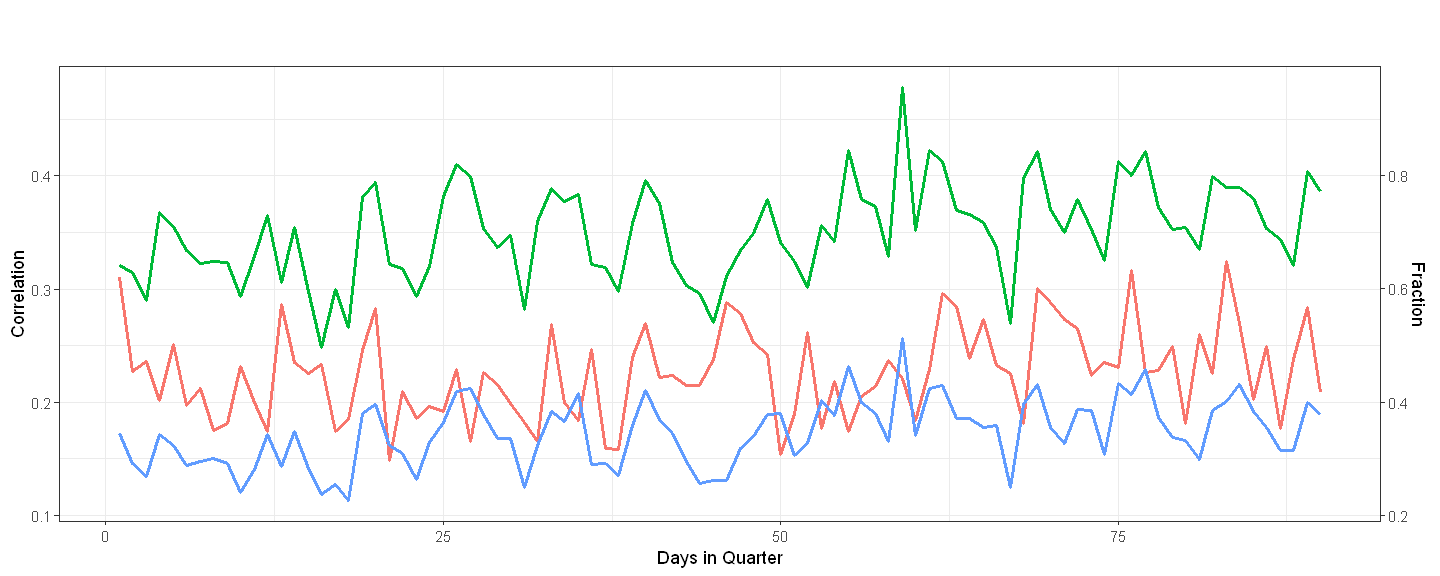

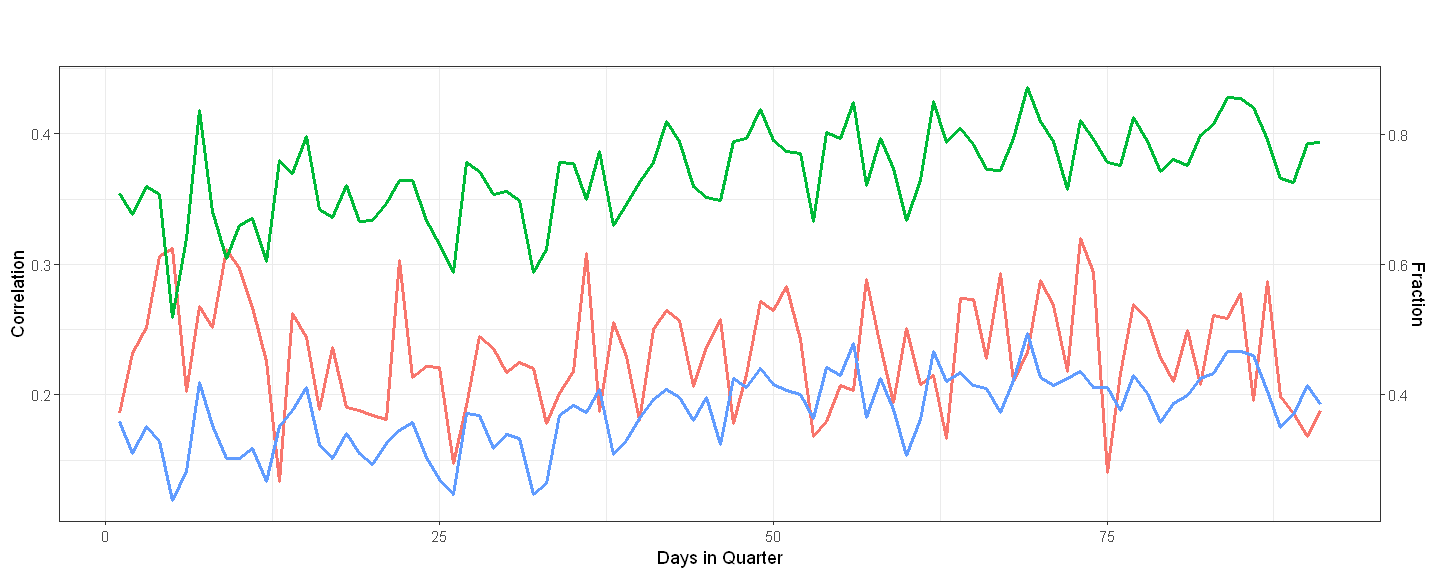

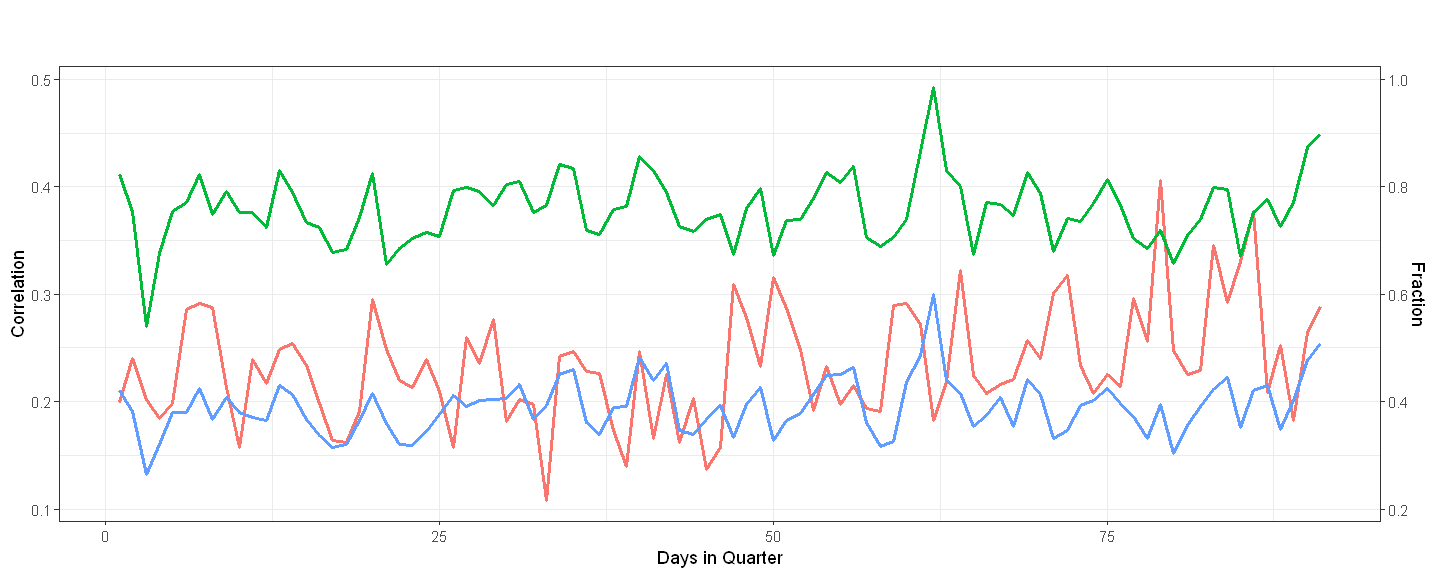

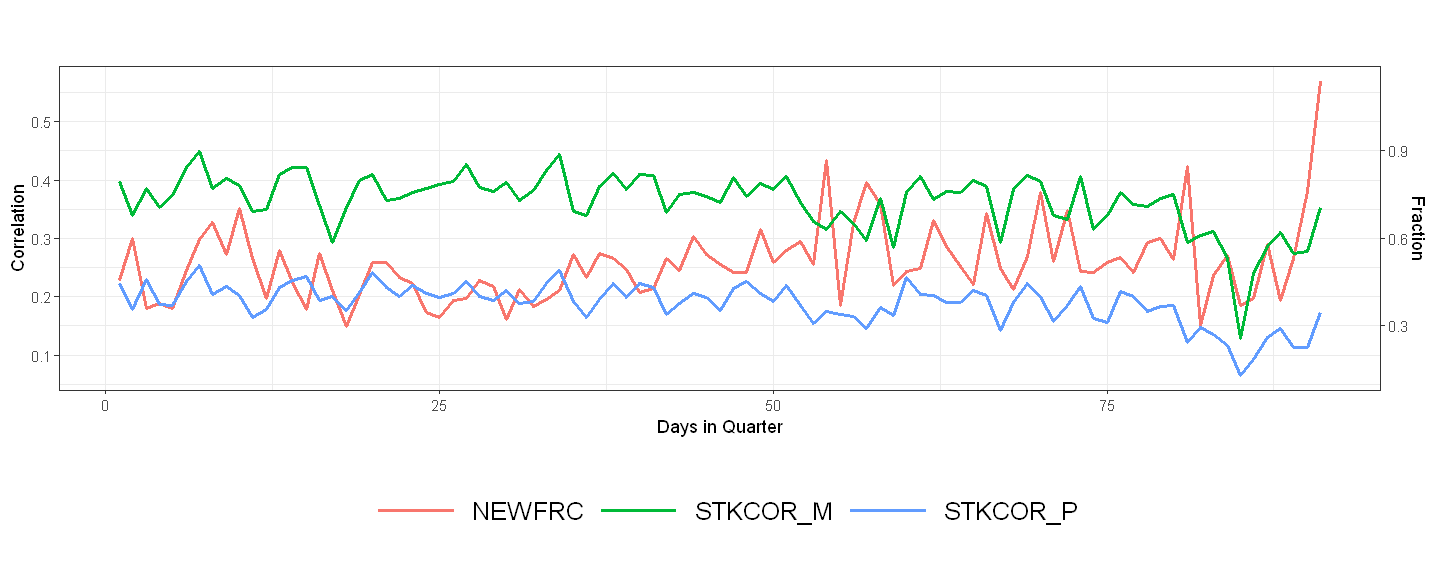

In [14]:
d_NEWFRC <- df[df$KEY=="NEWFRC",]
d_OTHER <- df[df$KEY!="NEWFRC",]
d_NEWFRC_rescale <- within(d_NEWFRC, {VALUE = VALUE*2})
df_2 <- rbind(d_OTHER, d_NEWFRC_rescale)

ggplot(df_2[df_2$QUARTER=="Q1",], aes(x=as.numeric(INDEX), y=VALUE, col=KEY)) +
    geom_line(size=1) +
    scale_y_continuous(sec.axis = sec_axis(~ . * 2, name="Fraction")) +
    labs(x="Days in Quarter", y="Correlation", title="", subtitle="") +
    theme_bw() +
    theme(legend.position='none')

ggplot(df_2[df_2$QUARTER=="Q2",], aes(x=as.numeric(INDEX), y=VALUE, col=KEY)) +
    geom_line(size=1) +
    scale_y_continuous(sec.axis = sec_axis(~ . * 2, name="Fraction")) +
    #facet_grid(rows = vars(QUARTER)) +
    labs(x="Days in Quarter", y="Correlation", title="", subtitle="") +
    theme_bw() +
    theme(legend.position='none')

ggplot(df_2[df_2$QUARTER=="Q3",], aes(x=as.numeric(INDEX), y=VALUE, col=KEY)) +
    geom_line(size=1) +
    scale_y_continuous(sec.axis = sec_axis(~ . * 2, name="Fraction")) +
    #facet_grid(rows = vars(QUARTER)) +
    labs(x="Days in Quarter", y="Correlation", title="", subtitle="") +
    theme_bw() +
    theme(legend.position='none')

ggplot(df_2[df_2$QUARTER=="Q4",], aes(x=as.numeric(INDEX), y=VALUE, col=KEY)) +
    geom_line(size=1) +
    scale_y_continuous(sec.axis = sec_axis(~ . * 2, name="Fraction")) +
    #facet_grid(rows = vars(QUARTER)) +
    labs(x="Days in Quarter", y="Correlation", title="", subtitle="") +
    theme_bw() +
    #theme(legend.position='none')
    theme(legend.position="bottom", legend.title = element_blank(), legend.key.size = unit(2, "cm"), legend.text=element_text(size=15))


rm(df_2)